In [1]:
import numpy as np
import cupy as cp
import ray
import astropy.units as u
from astropy.io import fits
from IPython.display import clear_output
import time
from pathlib import Path
from matplotlib.patches import Circle
from importlib import reload

import warnings
warnings.filterwarnings("ignore")

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import cgi_phasec_poppy
from cgi_phasec_poppy.imshows import *
from cgi_phasec_poppy.math_module import xp
reload(cgi_phasec_poppy)
data_dir = cgi_phasec_poppy.data_dir

import misc_funs as misc

dm1_flat = fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'spc_wide_band4_flattened_dm1.fits')
dm2_flat = fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'spc_wide_band4_flattened_dm2.fits')

iwa = 6
owa = 20

wavelength_c = 825e-9*u.m

nwaves = 5
bandwidth = 10/100
minwave = wavelength_c * (1 - bandwidth/2)
maxwave = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minwave, maxwave, nwaves )


In [2]:
reload(cgi_phasec_poppy.cgi)
reload(cgi_phasec_poppy.parallelized_cgi)

rayCGI = ray.remote(cgi_phasec_poppy.cgi.CGI) # make a ray actor class from the original CGI class  

kwargs = {
    'cgi_mode':'spc-wide',
    'npsf':150,
    'use_pupil_defocus':True,
    'use_opds':True,
    'polaxis':0,
}

actors = []
for i in range(nwaves):
    actors.append(rayCGI.options(num_cpus=2, num_gpus=1/8).remote(**kwargs))
    actors[i].setattr.remote('wavelength', wavelengths[i])

2024-03-21 08:53:26,114	INFO worker.py:1636 -- Started a local Ray instance.


# Without noise

(CGI pid=1785710) After resampling, optic phasor shape (1305, 1305) is smaller than input wavefront (2048, 2048); will zero-pad the rescaled array. [repeated 6x across cluster]
(CGI pid=1785710) /home/kianmilani/Projects/poppy/poppy/geometry.py:207: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
(CGI pid=1785710)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')


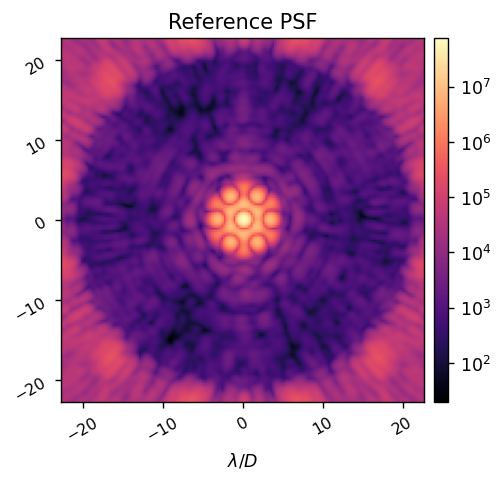

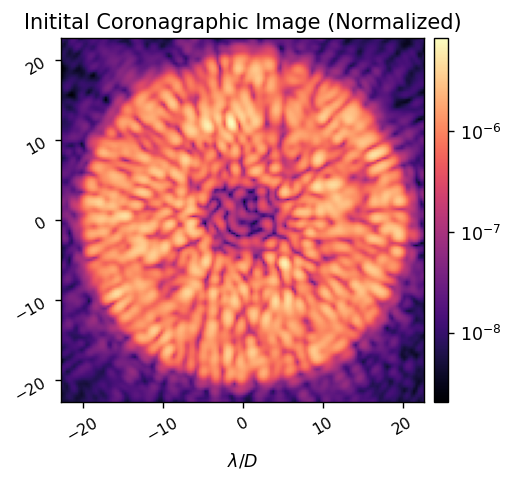

In [28]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors)

mode.set_dm1(2*dm1_flat)
# mode.set_dm2(dm2_flat)

mode.set_actor_attr('use_fpm',False)
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, 'Reference PSF',
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', symlognorm=True, )

max_ref = xp.max(ref_unocc_im)
mode.Imax_ref = max_ref

mode.set_actor_attr('use_fpm',True)

ref_im = mode.snap()
imshow1(ref_im, 'Initital Coronagraphic Image (Normalized)', 
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', symlognorm=True,)


# With noise

1.3624486320346218e-17 sr
	Flux for wavelength 7.838e-07 m: 7.662e+08 ph / (s m2)
	Flux for wavelength 8.044e-07 m: 7.115e+08 ph / (s m2)
	Flux for wavelength 8.250e-07 m: 6.650e+08 ph / (s m2)
	Flux for wavelength 8.456e-07 m: 6.195e+08 ph / (s m2)
	Flux for wavelength 8.663e-07 m: 5.809e+08 ph / (s m2)
Total flux: 3.343e+09 ph / (s m2)


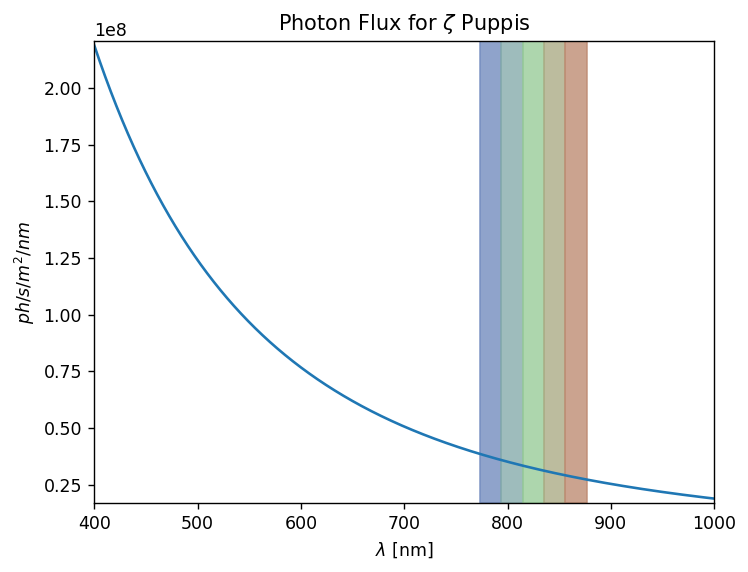

In [4]:
reload(cgi_phasec_poppy.source_flux)

minlam = 400*u.nm
maxlam = 1000*u.nm
nlam = int((maxlam-minlam).value*20) + 1
lambdas = np.linspace(minlam, maxlam, nlam)

from astropy.constants import h, c, k_B, R_sun

zpup = cgi_phasec_poppy.source_flux.SOURCE(wavelengths=wavelengths,
                                            temp=40000*u.K,
                                            distance=300*u.parsec,
                                            diameter=2*14*R_sun,
                                            name='$\zeta$ Puppis', 
                                            lambdas=lambdas,
                                           )

zpup.plot_spectrum_ph()
source_fluxes = zpup.calc_fluxes()
total_flux = np.sum(source_fluxes)

for i,flux in enumerate(source_fluxes):
    print(f'\tFlux for wavelength {wavelengths[i]:.3e}: {flux:.3e}')
    actors[i].setattr.remote('source_flux', source_fluxes[i])
print(f'Total flux: {total_flux:.3e}')

In [5]:
reload(cgi_phasec_poppy.imshows)
from cgi_phasec_poppy.imshows import *

In [7]:
pixelscale = 2.4*u.m/(1000*u.pix)

In [6]:
pixelscale = 2.363114*u.m/(1000*u.pix)
source_flux = ray.get(mode.actors[0].getattr.remote('source_flux'))
flux_per_pixel = source_flux * (pixelscale*u.pix)**2
flux_per_pixel, np.sqrt(flux_per_pixel)

(<Quantity 4278.57061687 ph / s>, <Quantity 65.41078364 ph(1/2) / s(1/2)>)

(CGI pid=1785710) After resampling, optic phasor shape (1305, 1305) is smaller than input wavefront (2048, 2048); will zero-pad the rescaled array. [repeated 91x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(CGI pid=1785709) /home/kianmilani/Projects/poppy/poppy/geometry.py:207: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1 [repeated 19x across cluster]
(CGI pid=1785709)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1') [repeated 19x across cluster]


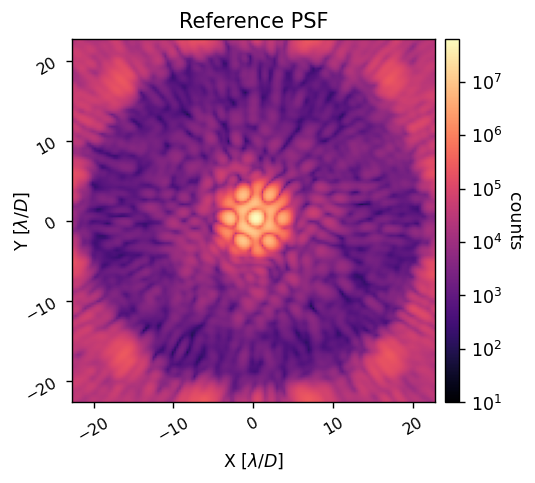

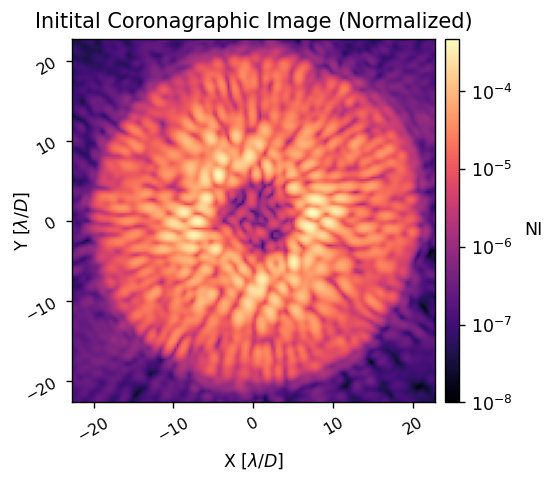

In [7]:


mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors)

mode.use_noise = True
mode.exp_time = 2*u.s
mode.gain = 1
mode.dark_current_rate = 0.05*u.electron/u.pix/u.hour
mode.read_noise = 120*u.electron/u.pix

mode.set_actor_attr('use_fpm',False)
ref_unocc_im = mode.snap()
fig,ax = imshow1(ref_unocc_im, 'Reference PSF',
        cbar_label='counts', clabel_rot=270,
        pxscl=mode.psf_pixelscale_lamD, xlabel='X [$\lambda/D$]', symlognorm=True, vmin=1e1, 
        display_fig=False, return_fig=True)
ax.set_ylabel('Y [$\lambda/D$]', labelpad=-5)
# fig.savefig('bb_unocc.pdf', format='pdf', bbox_inches="tight")
display(fig)


mode.set_actor_attr('use_fpm',True)
max_ref = xp.max(ref_unocc_im)
mode.Imax_ref = max_ref

mode.exp_time_ref = mode.exp_time
mode.gain_ref = mode.gain

mode.exp_time = 1/2*u.s
mode.gain = 1

ref_im = mode.snap()
fig,ax = imshow1(ref_im, 'Initital Coronagraphic Image (Normalized)', 
        cbar_label='NI', 
        pxscl=mode.psf_pixelscale_lamD, xlabel='X [$\lambda/D$]', symlognorm=True, vmin=1e-8,
                display_fig=False, return_fig=True)
# fig,ax = imshow1(ref_im, 'Coronagraphic Image',
#         cbar_label='counts', clabel_rot=270,
#         pxscl=mode.psf_pixelscale_lamD, xlabel='X [$\lambda/D$]', symlognorm=True, vmin=1e0, 
#         display_fig=False, return_fig=True)
ax.set_ylabel('Y [$\lambda/D$]', labelpad=-5)
# fig.savefig('bb_image.pdf', format='pdf', bbox_inches="tight")
display(fig)


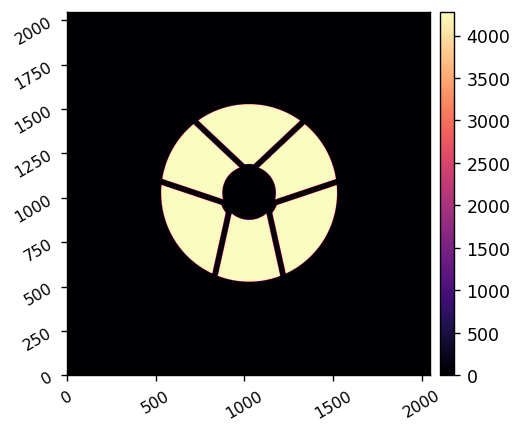

array(4278.57061687)

In [8]:
inwave = ray.get(mode.actors[0].getattr.remote('input_wavefront'))
imshow1(inwave.intensity)
inwave.intensity.max()

# Only using photon noise

(CGI pid=1785710) After resampling, optic phasor shape (1305, 1305) is smaller than input wavefront (2048, 2048); will zero-pad the rescaled array. [repeated 90x across cluster]
(CGI pid=1785709) /home/kianmilani/Projects/poppy/poppy/geometry.py:207: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1 [repeated 20x across cluster]
(CGI pid=1785709)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1') [repeated 20x across cluster]


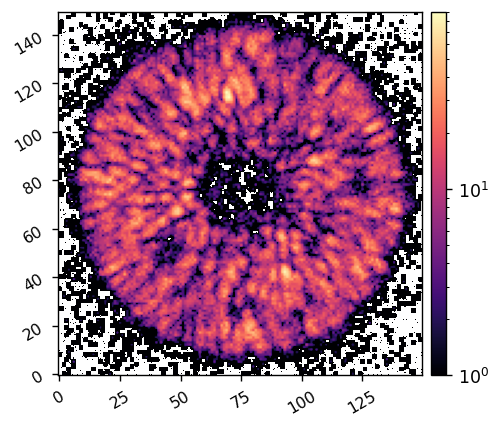

In [9]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors)
mode.set_dm1(dm1_flat)
mode.set_dm2(dm2_flat)

mode.use_photon_noise = True
mode.exp_time = 0.1

im = mode.snap()

imshow1(im, lognorm=True)


# Now using the EMCCD with photon noise
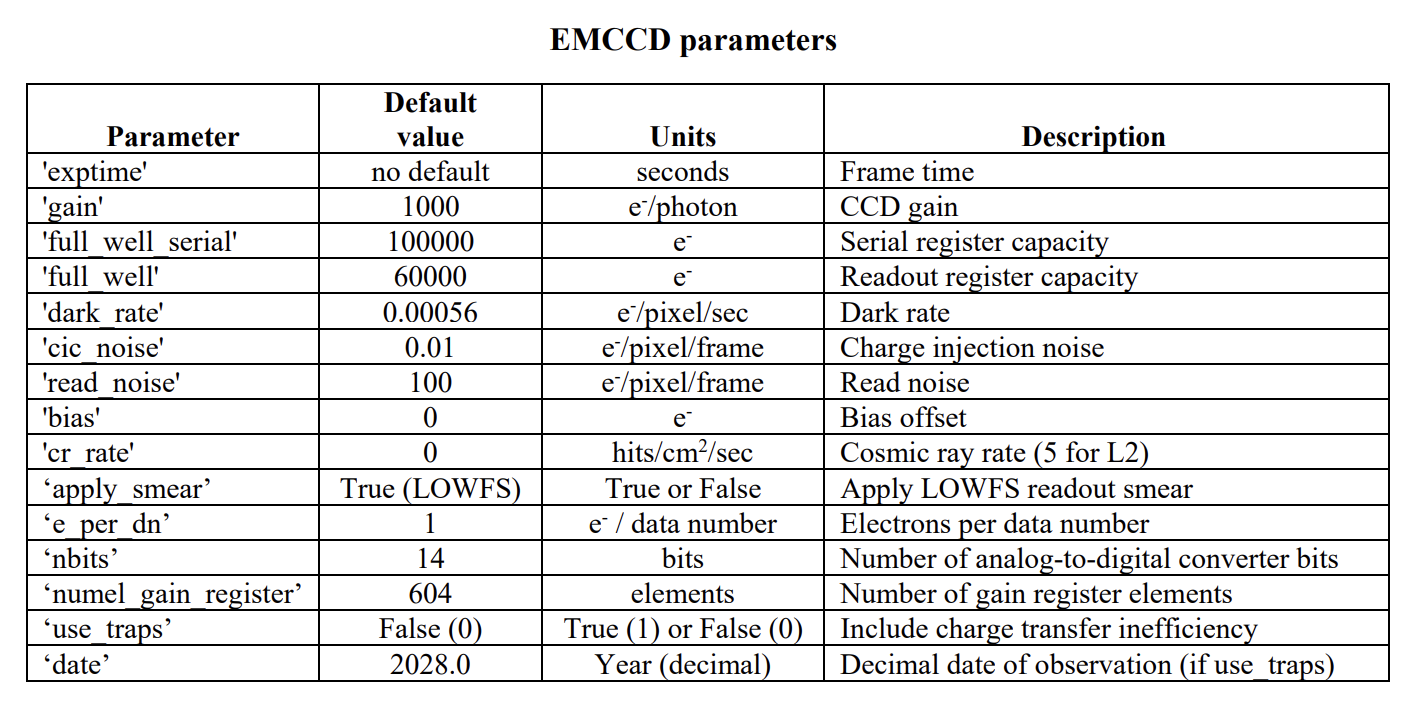

Computing each monochromatic image.


(CGI pid=1785710) After resampling, optic phasor shape (1305, 1305) is smaller than input wavefront (2048, 2048); will zero-pad the rescaled array. [repeated 45x across cluster]
(CGI pid=1785709) /home/kianmilani/Projects/poppy/poppy/geometry.py:207: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1 [repeated 10x across cluster]
(CGI pid=1785709)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1') [repeated 10x across cluster]


Simulating EMCCD frame 1.
Simulating EMCCD frame 2.
Simulating EMCCD frame 3.
Simulating EMCCD frame 4.
Simulating EMCCD frame 5.


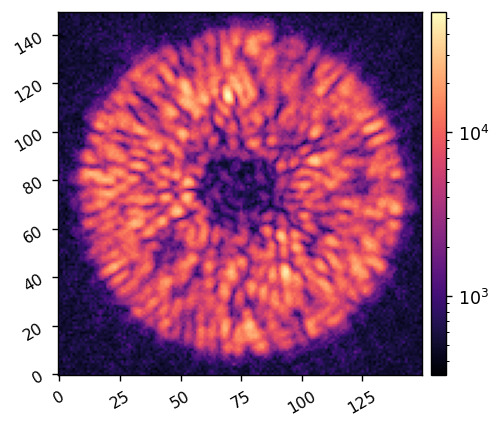

In [10]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors, dm1_ref=dm1_flat, dm2_ref=dm2_flat)

from emccd_detect import emccd_detect
meta_path = Path('/home/kianmilani/Projects/emccd_detect/emccd_detect/emccd_detect/util/metadata.yaml')

em_gain = 250
full_well_image=60000.  # e-
full_well_serial=100000.  # e-
#status=1,
dark_current=8e-4  # e-/pix/s
cic=0.01  # e-/pix/frame
read_noise=120.  # e-/pix/frame
bias=500.  # e-
qe=0.5
cr_rate=0.  # hits/cm^2/s
pixel_pitch=13e-6  # m
eperdn=1 #7.,
nbits=16#14,
numel_gain_register=604

emccd = emccd_detect.EMCCDDetect(em_gain=em_gain,
                                    full_well_image=full_well_image,  # e-
                                    full_well_serial=full_well_serial,  # e-
                                    #status=status,
                                    dark_current=dark_current,  # e-/pix/s
                                    cic=cic,  # e-/pix/frame
                                    read_noise=read_noise,  # e-/pix/frame
                                    bias=bias,  # e-
                                    qe=qe,
                                    cr_rate=cr_rate,  # hits/cm^2/s
                                    pixel_pitch=pixel_pitch,  # m
                                    eperdn=eperdn,
                                    nbits=nbits,
                                    numel_gain_register=numel_gain_register,
                                    meta_path=meta_path
                                    )

mode.use_photon_noise = True
mode.EMCCD = emccd

mode.Nframes = 5
mode.exp_time = 0.5
im = mode.snap(quiet=False)
imshow1(im, lognorm=True)

# Normalizing to get normalized intensity images with noise.

Computing each monochromatic image.


(CGI pid=1785709) /home/kianmilani/Projects/poppy/poppy/geometry.py:207: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1 [repeated 30x across cluster]
(CGI pid=1785709)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1') [repeated 30x across cluster]
(CGI pid=1785710) After resampling, optic phasor shape (1305, 1305) is smaller than input wavefront (2048, 2048); will zero-pad the rescaled array. [repeated 135x across cluster]


Generating all frames based on computed flux for exposure time 1/3: 0.000s
Generating all frames based on computed flux for exposure time 2/3: 0.000s
Generating all frames based on computed flux for exposure time 3/3: 0.000s
Computing each monochromatic image.
Generating all frames based on computed flux for exposure time 1/3: 0.000s
Generating all frames based on computed flux for exposure time 2/3: 0.000s
Generating all frames based on computed flux for exposure time 3/3: 0.000s


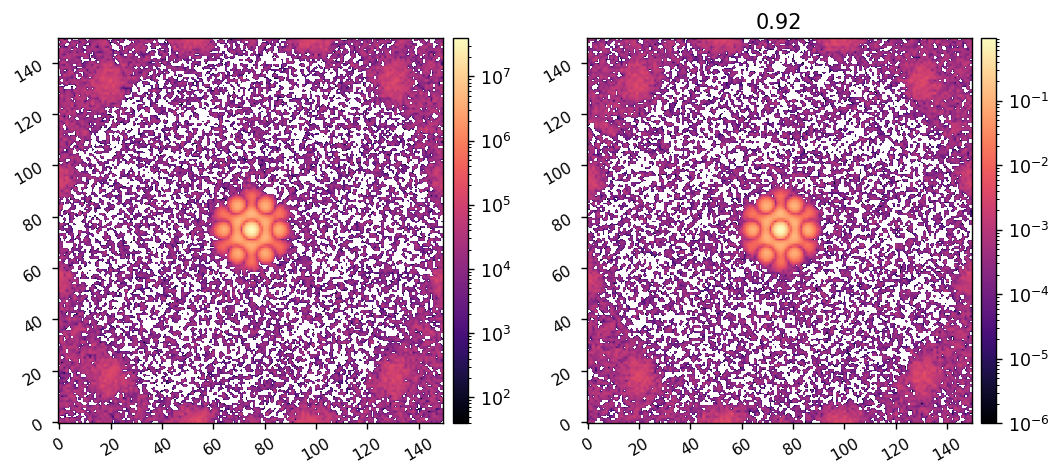

Computing each monochromatic image.


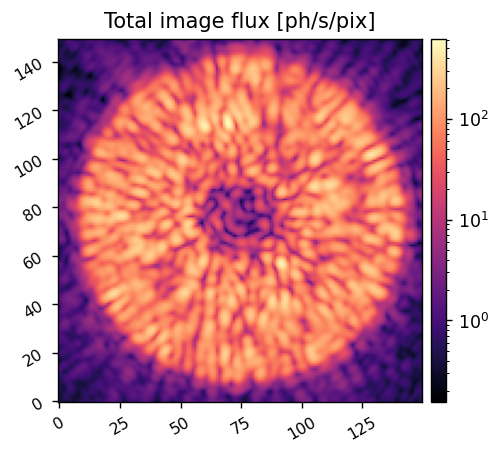

Generating all frames based on computed flux for exposure time 1/1: 1.000s


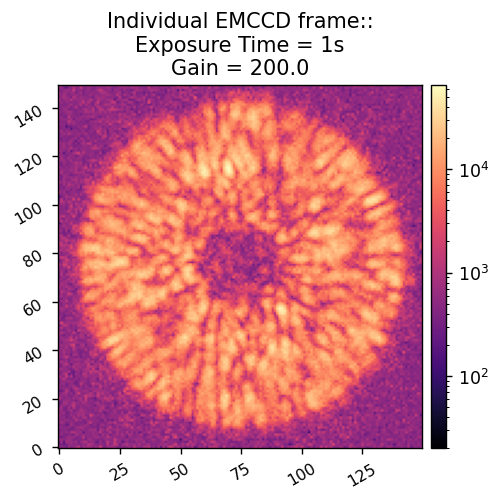

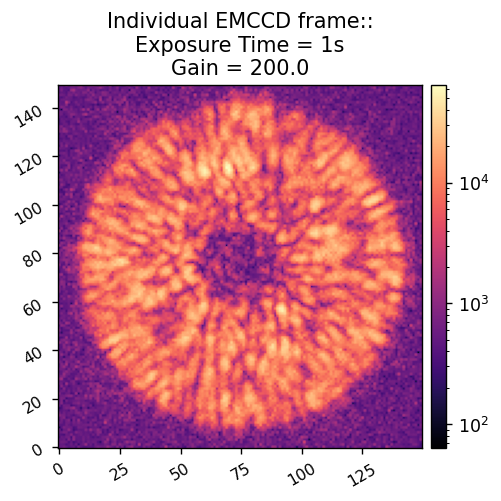

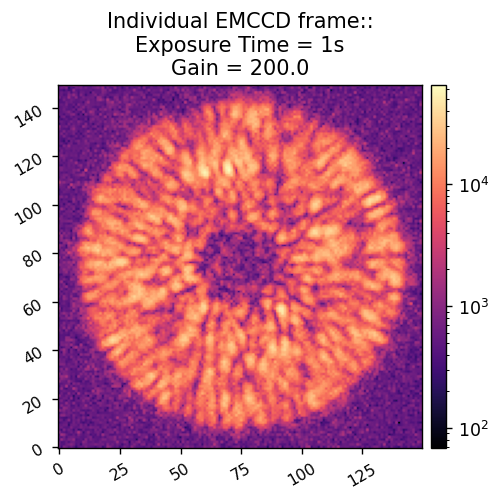

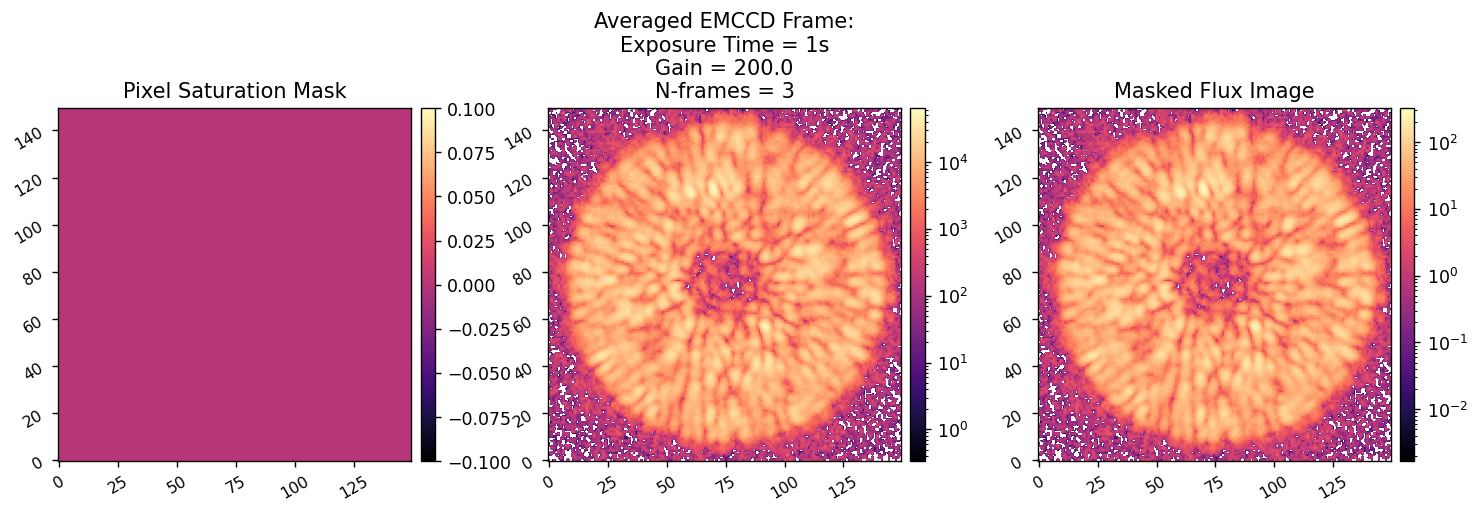

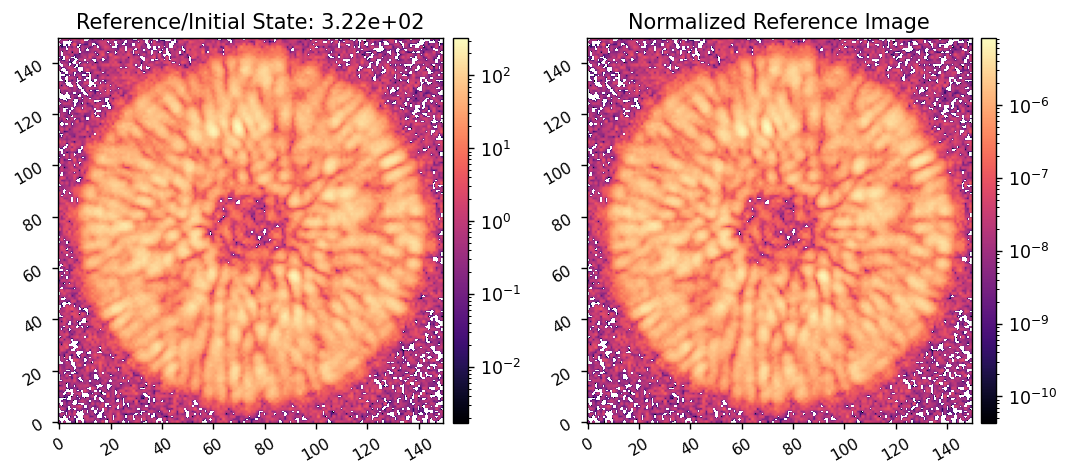

In [40]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors, 
                                                         dm1_ref=2*dm1_flat, 
                                                        #  dm2_ref=dm2_flat, 
                                                         )

mode.EMCCD = emccd

unocc_em_gain = 200

mode.set_actor_attr('use_fpm',False)
mode.EMCCD.em_gain = unocc_em_gain

mode.Nframes_list = [10, 2, 2]
mode.exp_times_list = [0.000005, 0.00005, 0.0001]
mode.subtract_bias = True
raw_im = mode.snap_many(quiet=False)

mode.normalize = True
mode.exp_times_list = [0.000005, 0.00005, 0.0001]
mode.Imax_ref = xp.max(raw_im.max())
mode.em_gain_ref = unocc_em_gain

ref_unocc_im = mode.snap_many(quiet=False)
imshow2(raw_im, ref_unocc_im, '', f'{xp.max(ref_unocc_im):.2f}', 
        lognorm=True, vmin1=mode.Imax_ref*1e-6, vmin2=1e-6)

mode.EMCCD.em_gain = 200

mode.set_actor_attr('use_fpm',True)
mode.exp_times_list = [1]
mode.Nframes_list = [3]
mode.gain_list = [200]
ref_im = mode.snap_many(quiet=False, plot=True)

imshow2(ref_im*mode.Imax_ref, ref_im,
        f'Reference/Initial State: {xp.max(ref_im*mode.Imax_ref):.2e}', 
        'Normalized Reference Image',
        lognorm=True,)